# Per Gene Enhancer TF Plots

Create temporal graphs for each gene consisting of enhancers and TFs for different cell states. See `20210530` analysis.

Inputs:
1. Cluster config
2. Peak-gene links
3. Motif hits per cluster

In [1]:
library(GenomicRanges)
library(dplyr)
library(ggnetwork)
library(igraph)
library(intergraph)
library(network)
library(patchwork)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

## Load Inputs

In [4]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# print friendly
cluster_config[9, "description"] = "Partially\nreprogrammed"

cluster_config = cluster_config[!is.na(cluster_config$cluster), ]
rownames(cluster_config) = as.factor(cluster_config$cluster)
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#B03743,Fibroblast,1
2,2,#E85F6D,Fibroblast-like,3
3,3,#7C2730,Fibroblast-like,2
4,4,#F0A118,Intermediate,12
5,5,#78A824,Pre-iPSC,13
6,6,#A6D854,Pre-iPSC,14
7,7,#F01D35,Fibroblast-like,5
8,8,#13C4A3,iPSC,15
9,9,#406614,Partially reprogrammed,10


In [5]:
p2g_links = read.table("../../analysis/20200925_Peak2Gene/peak2gene_links/RNA_20210725_n59378_ATAC_20210717_n62599/20210826_all_fdr1e-4.tsv", 
                      header=T)

p2g_links = p2g_links[abs(p2g_links$Correlation)>0.45, ]
dim(p2g_links)
head(p2g_links)

[1] 156016      6

,peak,gene,Correlation,FDR,VarQATAC,VarQRNA
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
6,chr1:906705-907205,LINC01128,0.5794615,1.330099e-44,0.9578667,0.4633998
13,chr1:938013-938513,LINC01128,0.4854523,1.111231e-29,0.9270705,0.4633998
19,chr1:998731-999231,LINC01128,0.5677101,1.820662e-42,0.9439886,0.4633998
23,chr1:1066642-1067142,LINC01128,0.4513822,2.463342e-25,0.7876495,0.4633998
52,chr1:940711-941211,LINC02593,0.4637963,7.331539e-27,0.8949690,0.2648434
53,chr1:941520-942020,LINC02593,0.4999406,1.102645e-31,0.9715865,0.2648434


In [6]:
pwm_hits_per_cluster = list()

for (i in seq(nrow(cluster_config))) {
    c = read.table(sprintf("../../analysis/20211007_motif_consolidation/20210820_chrombpnet_lite/importance_thresholded/cluster_idx%d.0.99.bed", i))
    colnames(c) = c("chr", "start", "end", "name", "score", "strand", "seq", "imp")

    pwm_hits_per_cluster[[i]] = GRanges(c)
}

In [7]:
sort(as.character(unique(pwm_hits_per_cluster[[1]]$name)))

[1] "AP2A_MOUSE.H11MO.0.A"  "ATF2_HUMAN.H11MO.0.B"  "CEBPA_MA0102.3"       
 [4] "COE1_HUMAN.H11MO.0.A"  "CTCF_MA0139.1"         "EGR2_MOUSE.H11MO.0.A" 
 [7] "ETS1_MOUSE.H11MO.0.A"  "FOSL2_HUMAN.H11MO.0.A" "FOXC2_MA0846.1"       
[10] "GRHL1_CP2_1"           "IRF1_MA0050.2"         "KLF3_HUMAN.H11MO.0.B" 
[13] "MEF2D_MOUSE.H11MO.0.A" "NFIC_HUMAN.H11MO.0.A"  "NFKB1_HUMAN.H11MO.1.B"
[16] "NFYB_HUMAN.H11MO.0.A"  "NRF1_HUMAN.H11MO.0.A"  "PO5F1_MOUSE.H11MO.0.A"
[19] "POU3F2_MA0787.1"       "REST_MA0138.2"         "RFX2_MOUSE.H11MO.0.A" 
[22] "RUNX3_HUMAN.H11MO.0.A" "SIX1_HUMAN.H11MO.0.A"  "SOX15_MA1152.1"       
[25] "SP2_HUMAN.H11MO.0.A"   "TEAD1_TEA_2"           "TEAD4_HUMAN.H11MO.0.A"
[28] "TWST1_MOUSE.H11MO.0.B" "ZIC3_HUMAN.H11MO.0.B"  "ZN143_MOUSE.H11MO.0.A"

In [276]:
MOTIF_SUBSET  = c("PO5F1_MOUSE.H11MO.0.A"="OCTSOX",
                  "SOX15_MA1152.1"="SOX",
                  "KLF3_HUMAN.H11MO.0.B"="KLF/SP", 
                  "CTCF_MA0139.1"="CTCF",
                  "AP2A_MOUSE.H11MO.0.A"="TFAP2",
                  "FOSL2_HUMAN.H11MO.0.A"="AP1",
                  "RUNX3_HUMAN.H11MO.0.A"="RUNX",
                  "TEAD4_HUMAN.H11MO.0.A"="TEAD"
#                  "ZIC3_HUMAN.H11MO.0.B",
                 )

In [277]:
filtered_pwm_hits_per_cluster = list()

for (i in seq(nrow(cluster_config))) {
    filtered_pwm_hits_per_cluster[[i]] = pwm_hits_per_cluster[[i]][pwm_hits_per_cluster[[i]]$name %in% names(MOTIF_SUBSET)]
}

filtered_pwm_hits_per_cluster[[1]]

GRanges object with 138500 ranges and 4 metadata columns:
           seqnames            ranges strand |                  name
              <Rle>         <IRanges>  <Rle> |              <factor>
       [1]     chr1       38706-38718      + | FOSL2_HUMAN.H11MO.0.A
       [2]     chr1       91417-91436      - |         CTCF_MA0139.1
       [3]     chr1       91419-91438      + |         CTCF_MA0139.1
       [4]     chr1       91429-91448      + |         CTCF_MA0139.1
       [5]     chr1     144027-144039      + | FOSL2_HUMAN.H11MO.0.A
       ...      ...               ...    ... .                   ...
  [138496]     chrY 24270858-24270870      - | FOSL2_HUMAN.H11MO.0.A
  [138497]     chrY 24363865-24363877      - | FOSL2_HUMAN.H11MO.0.A
  [138498]     chrY 25306260-25306272      + | FOSL2_HUMAN.H11MO.0.A
  [138499]     chrY 25399276-25399288      + | FOSL2_HUMAN.H11MO.0.A
  [138500]     chrY 26315266-26315285      - |         CTCF_MA0139.1
                   score                 seq 

In [281]:
for (i in seq(nrow(cluster_config))) {
    overlap_with_os = unique(queryHits(findOverlaps(filtered_pwm_hits_per_cluster[[i]], 
                                                filtered_pwm_hits_per_cluster[[i]][filtered_pwm_hits_per_cluster[[i]]$name=="PO5F1_MOUSE.H11MO.0.A"]))) 
    sox_overlap_with_os = overlap_with_os[overlap_with_os %in% which(filtered_pwm_hits_per_cluster[[i]]$name=="SOX15_MA1152.1")]

    filtered_pwm_hits_per_cluster[[i]] = filtered_pwm_hits_per_cluster[[i]][!(seq(length(filtered_pwm_hits_per_cluster[[i]])) %in% sox_overlap_with_os)]
}

filtered_pwm_hits_per_cluster[[1]]

GRanges object with 138494 ranges and 4 metadata columns:
           seqnames            ranges strand |                  name
              <Rle>         <IRanges>  <Rle> |              <factor>
       [1]     chr1       38706-38718      + | FOSL2_HUMAN.H11MO.0.A
       [2]     chr1       91417-91436      - |         CTCF_MA0139.1
       [3]     chr1       91419-91438      + |         CTCF_MA0139.1
       [4]     chr1       91429-91448      + |         CTCF_MA0139.1
       [5]     chr1     144027-144039      + | FOSL2_HUMAN.H11MO.0.A
       ...      ...               ...    ... .                   ...
  [138490]     chrY 24270858-24270870      - | FOSL2_HUMAN.H11MO.0.A
  [138491]     chrY 24363865-24363877      - | FOSL2_HUMAN.H11MO.0.A
  [138492]     chrY 25306260-25306272      + | FOSL2_HUMAN.H11MO.0.A
  [138493]     chrY 25399276-25399288      + | FOSL2_HUMAN.H11MO.0.A
  [138494]     chrY 26315266-26315285      - |         CTCF_MA0139.1
                   score                 seq 

In [282]:
for (i in seq(nrow(cluster_config))) {
    overlap_with_klf = unique(queryHits(findOverlaps(filtered_pwm_hits_per_cluster[[i]], 
                                                filtered_pwm_hits_per_cluster[[i]][filtered_pwm_hits_per_cluster[[i]]$name=="KLF3_HUMAN.H11MO.0.B"]))) 
    ap2_overlap_with_klf = overlap_with_klf[overlap_with_klf %in% which(filtered_pwm_hits_per_cluster[[i]]$name=="AP2A_MOUSE.H11MO.0.A")]

    filtered_pwm_hits_per_cluster[[i]] = filtered_pwm_hits_per_cluster[[i]][!(seq(length(filtered_pwm_hits_per_cluster[[i]])) %in% ap2_overlap_with_klf)]
}

filtered_pwm_hits_per_cluster[[1]]

GRanges object with 137972 ranges and 4 metadata columns:
           seqnames            ranges strand |                  name
              <Rle>         <IRanges>  <Rle> |              <factor>
       [1]     chr1       38706-38718      + | FOSL2_HUMAN.H11MO.0.A
       [2]     chr1       91417-91436      - |         CTCF_MA0139.1
       [3]     chr1       91419-91438      + |         CTCF_MA0139.1
       [4]     chr1       91429-91448      + |         CTCF_MA0139.1
       [5]     chr1     144027-144039      + | FOSL2_HUMAN.H11MO.0.A
       ...      ...               ...    ... .                   ...
  [137968]     chrY 24270858-24270870      - | FOSL2_HUMAN.H11MO.0.A
  [137969]     chrY 24363865-24363877      - | FOSL2_HUMAN.H11MO.0.A
  [137970]     chrY 25306260-25306272      + | FOSL2_HUMAN.H11MO.0.A
  [137971]     chrY 25399276-25399288      + | FOSL2_HUMAN.H11MO.0.A
  [137972]     chrY 26315266-26315285      - |         CTCF_MA0139.1
                   score                 seq 

In [285]:
for (i in seq(nrow(cluster_config))) {
    overlap_with_ctcf = unique(queryHits(findOverlaps(filtered_pwm_hits_per_cluster[[i]], 
                                                filtered_pwm_hits_per_cluster[[i]][filtered_pwm_hits_per_cluster[[i]]$name=="CTCF_MA0139.1"]))) 
    klf_overlap_with_ctcf = overlap_with_ctcf[overlap_with_ctcf %in% which(filtered_pwm_hits_per_cluster[[i]]$name=="KLF3_HUMAN.H11MO.0.B")]

    filtered_pwm_hits_per_cluster[[i]] = filtered_pwm_hits_per_cluster[[i]][!(seq(length(filtered_pwm_hits_per_cluster[[i]])) %in% klf_overlap_with_ctcf)]
}

filtered_pwm_hits_per_cluster[[1]]

GRanges object with 135514 ranges and 4 metadata columns:
           seqnames            ranges strand |                  name
              <Rle>         <IRanges>  <Rle> |              <factor>
       [1]     chr1       38706-38718      + | FOSL2_HUMAN.H11MO.0.A
       [2]     chr1       91417-91436      - |         CTCF_MA0139.1
       [3]     chr1       91419-91438      + |         CTCF_MA0139.1
       [4]     chr1       91429-91448      + |         CTCF_MA0139.1
       [5]     chr1     144027-144039      + | FOSL2_HUMAN.H11MO.0.A
       ...      ...               ...    ... .                   ...
  [135510]     chrY 24270858-24270870      - | FOSL2_HUMAN.H11MO.0.A
  [135511]     chrY 24363865-24363877      - | FOSL2_HUMAN.H11MO.0.A
  [135512]     chrY 25306260-25306272      + | FOSL2_HUMAN.H11MO.0.A
  [135513]     chrY 25399276-25399288      + | FOSL2_HUMAN.H11MO.0.A
  [135514]     chrY 26315266-26315285      - |         CTCF_MA0139.1
                   score                 seq 

In [287]:
# now remove CTCF
for (i in seq(nrow(cluster_config))) {
    filtered_pwm_hits_per_cluster[[i]] = filtered_pwm_hits_per_cluster[[i]][as.character(filtered_pwm_hits_per_cluster[[i]]$name) != "CTCF_MA0139.1"]
}
filtered_pwm_hits_per_cluster[[1]]

GRanges object with 101812 ranges and 4 metadata columns:
           seqnames            ranges strand |                  name
              <Rle>         <IRanges>  <Rle> |              <factor>
       [1]     chr1       38706-38718      + | FOSL2_HUMAN.H11MO.0.A
       [2]     chr1     144027-144039      + | FOSL2_HUMAN.H11MO.0.A
       [3]     chr1     178814-178826      + | FOSL2_HUMAN.H11MO.0.A
       [4]     chr1     179332-179344      + | FOSL2_HUMAN.H11MO.0.A
       [5]     chr1     203620-203632      + | FOSL2_HUMAN.H11MO.0.A
       ...      ...               ...    ... .                   ...
  [101808]     chrY 20575670-20575689      + |  KLF3_HUMAN.H11MO.0.B
  [101809]     chrY 24270858-24270870      - | FOSL2_HUMAN.H11MO.0.A
  [101810]     chrY 24363865-24363877      - | FOSL2_HUMAN.H11MO.0.A
  [101811]     chrY 25306260-25306272      + | FOSL2_HUMAN.H11MO.0.A
  [101812]     chrY 25399276-25399288      + | FOSL2_HUMAN.H11MO.0.A
                   score                 seq 

In [288]:
sample(filtered_pwm_hits_per_cluster[[1]][filtered_pwm_hits_per_cluster[[1]]$name=="SOX15_MA1152.1"], 10)

GRanges object with 10 ranges and 4 metadata columns:
       seqnames              ranges strand |           name         score
          <Rle>           <IRanges>  <Rle> |       <factor>     <numeric>
   [1]     chr4 182604467-182604477      + | SOX15_MA1152.1 7.59359026809
   [2]    chr16   18933135-18933145      + | SOX15_MA1152.1 7.95603398868
   [3]     chr8 116037466-116037476      - | SOX15_MA1152.1 7.59359026809
   [4]    chr10   74501034-74501044      - | SOX15_MA1152.1 7.95603398868
   [5]    chr13 111233270-111233280      - | SOX15_MA1152.1 7.40386302108
   [6]     chr5 124308576-124308586      + | SOX15_MA1152.1 7.40386302108
   [7]     chr6     4350722-4350732      - | SOX15_MA1152.1 8.14576123569
   [8]     chr8 100883956-100883966      + | SOX15_MA1152.1 7.41128088626
   [9]    chr18   28099434-28099444      - | SOX15_MA1152.1 7.55596455068
  [10]     chr6   72273125-72273135      - | SOX15_MA1152.1 7.59359026809
              seq               imp
         <factor>     

In [289]:
filtered_pwm_hits_per_cluster[[8]][queryHits(findOverlaps(filtered_pwm_hits_per_cluster[[8]], GRanges("chr12:7758298-7758825")))]

GRanges object with 1 range and 4 metadata columns:
      seqnames          ranges strand |                  name         score
         <Rle>       <IRanges>  <Rle> |              <factor>     <numeric>
  [1]    chr12 7758387-7758403      + | PO5F1_MOUSE.H11MO.0.A 8.47794635579
                   seq               imp
              <factor>         <numeric>
  [1] CTTTTCTCTTGTTAAT 0.892850164113345
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [19]:
gene_list = as.vector(read.table("../../analysis/20200828_RNA_Seurat/gene_sets/20211004_znorm_n15/idx13.txt")$V1)
length(gene_list)

[1] 387

In [153]:
head(rev(sort(table(p2g_links$gene)[gene_list])),50)


    GCNT2    SEMA6A    MAP4K1    ZNF486     ZNF90   ZSCAN10     NLRP2     FOXH1 
       71        65        61        61        60        57        56        56 
  FAM71E1     NLRP7    SPINT2    RIMKLB     FRAT2    JARID2    TUBB2B     CLDN6 
       52        51        51        48        48        48        46        45 
    TOMM7    LEFTY1     CECR2      TJP3    SCNN1A      MYCN     USP28    PRDM14 
       45        45        44        44        44        44        42        42 
    MKRN1    ZNF138    B3GNT7     TDGF1    ZNF675      CRB3  ARHGEF10     CLDN3 
       42        42        42        41        40        40        40        40 
     GRM4      GLDC    TRIM71     APOC1     TCEA1    UNC93A LINC01108    ZNF600 
       40        39        39        38        38        38        38        37 
    VENTX      TJP2      CDH3      FGD4     BICD1    TESMIN     ALOX5    RBPMS2 
       37        37        36        36        36        36        36        35 
    NODAL  ARHGEF35 
      

In [341]:
GENE = "FN1"

In [342]:
# CLUSTERS = c(1, 11, 14, 4, 5, 6, 8)
CLUSTERS = c(1, 11, 4, 6, 8)

In [343]:
gene_links = p2g_links[p2g_links$gene==GENE, ]
gene_links_gr = GRanges(gene_links$peak)
dim(gene_links)
head(gene_links)

[1] 36  6

,peak,gene,Correlation,FDR,VarQATAC,VarQRNA
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
447319,chr2:215231123-215231623,FN1,0.5647502,6.090354e-42,0.3919629,0.9994408
447332,chr2:215354625-215355125,FN1,0.5996835,1.725086e-48,0.7973009,0.9994408
447334,chr2:215356743-215357243,FN1,0.5717132,3.488739e-43,0.6468121,0.9994408
447338,chr2:215367667-215368167,FN1,0.5304270,3.129437e-36,0.8119531,0.9994408
447342,chr2:215373893-215374393,FN1,0.4592462,2.705191e-26,0.4581888,0.9994408
447343,chr2:215377279-215377779,FN1,0.5482224,4.145839e-39,0.6673975,0.9994408


In [344]:
filtered_pwm_hits_per_cluster[[1]][queryHits(findOverlaps(filtered_pwm_hits_per_cluster[[1]], GRanges("chr2:237201489-237202921")))]

GRanges object with 2 ranges and 4 metadata columns:
      seqnames              ranges strand |                  name         score
         <Rle>           <IRanges>  <Rle> |              <factor>     <numeric>
  [1]     chr2 237202158-237202170      + | FOSL2_HUMAN.H11MO.0.A 12.1960064721
  [2]     chr2 237202220-237202232      + | FOSL2_HUMAN.H11MO.0.A 11.4277506963
               seq              imp
          <factor>        <numeric>
  [1] GGGTGAGTCACC 2.59098923549192
  [2] GGATGAGTCACA 2.17997367371667
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [345]:

cluster_x_peak_x_motif_cts = list()

for (i in CLUSTERS) {
    subset_filtered_pwm_hits = filtered_pwm_hits_per_cluster[[i]]
    overlaps = findOverlaps(gene_links_gr, subset_filtered_pwm_hits)
    tdf = data.frame(peak=as.character(gene_links_gr[queryHits(overlaps)]),
                 m=subset_filtered_pwm_hits[subjectHits(overlaps)]$name)

    cluster_x_peak_x_motif_cts[[i]] = tdf  %>% count(peak, m, name="cts")
}

In [346]:
all_peak_motif = (do.call(rbind, cluster_x_peak_x_motif_cts) %>% count(peak, m))[,1:2]
rownames(all_peak_motif) = paste(all_peak_motif$peak, all_peak_motif$m, sep='_')

for (i in CLUSTERS) {
    all_peak_motif[,sprintf("C%d_cts", i)] = 0
    all_peak_motif[paste(cluster_x_peak_x_motif_cts[[i]]$peak,
                        cluster_x_peak_x_motif_cts[[i]]$m,
                        sep='_'), sprintf("C%d_cts", i)] = cluster_x_peak_x_motif_cts[[i]]$cts
    
}
head(all_peak_motif)

,peak,m,C1_cts,C11_cts,C4_cts,C6_cts,C8_cts
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr2:215367667-215368167_FOSL2_HUMAN.H11MO.0.A,chr2:215367667-215368167,FOSL2_HUMAN.H11MO.0.A,1,0,0,0,0
chr2:215402022-215402522_RUNX3_HUMAN.H11MO.0.A,chr2:215402022-215402522,RUNX3_HUMAN.H11MO.0.A,2,0,0,0,0
chr2:215410819-215411319_FOSL2_HUMAN.H11MO.0.A,chr2:215410819-215411319,FOSL2_HUMAN.H11MO.0.A,2,2,2,0,0
chr2:215410819-215411319_PO5F1_MOUSE.H11MO.0.A,chr2:215410819-215411319,PO5F1_MOUSE.H11MO.0.A,0,1,0,0,0
chr2:215433535-215434035_FOSL2_HUMAN.H11MO.0.A,chr2:215433535-215434035,FOSL2_HUMAN.H11MO.0.A,1,0,0,0,0
chr2:215528502-215529002_AP2A_MOUSE.H11MO.0.A,chr2:215528502-215529002,AP2A_MOUSE.H11MO.0.A,0,0,1,0,0


In [347]:
head(all_peak_motif[grepl("zic", all_peak_motif$m, ignore.case = T), ])

peak,m,C1_cts,C11_cts,C4_cts,C6_cts,C8_cts
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [348]:
# manual interventions
# AP2 OCT-SOX SOX are not active till C11
# AP2 not active in iPSC
all_peak_motif[grepl("pou|sox|ap2", all_peak_motif$m, ignore.case = T), "C1_cts"] = 0
all_peak_motif[grepl("ap2", all_peak_motif$m, ignore.case = T), "C11_cts"] = 0
all_peak_motif[grepl("ap2", all_peak_motif$m, ignore.case = T), "C8_cts"] = 0
all_peak_motif[grepl("zic", all_peak_motif$m, ignore.case = T), c("C1_cts", "C11_cts", "C4_cts", "C6_cts")] = 0

dim(all_peak_motif)
all_peak_motif = all_peak_motif[rowSums(all_peak_motif[,3:ncol(all_peak_motif)])>0, ]
dim(all_peak_motif)

[1] 25  7

[1] 25  7

In [356]:
mat = as.matrix(all_peak_motif)

g = graph_from_edgelist(mat[,1:2])

edge_attr_list = list()
for (i in CLUSTERS) {
    edge_attr_list[[sprintf("C%d_cts", i)]] = 0.01*as.numeric(mat[,sprintf("C%d_cts", i)])
}

edge_attr(g) <- edge_attr_list

node_names = c()
for (x in V(g)$name) {
    if (grepl("chr", x)) {
        node_names = c(node_names, "")
    }
    
    else {
        node_names = c(node_names, MOTIF_SUBSET[x]) #toupper(strsplit(x, "_")[[1]][[1]]))
    }
}

vertex_attr(g) <- list(name=V(g)$name, # needs to be there for some reason
                       type=ifelse(grepl("chr", V(g)$name), "Enh", "TF"),
                       print_type=node_names,
                       size=ifelse(grepl("chr", V(g)$name), 1, 10)
                      )
g = asNetwork(g)

In [357]:
plot_g = ggnetwork(g)

In [358]:
head(as.character(all_peak_motif$peak))

[1] "chr2:215367667-215368167" "chr2:215402022-215402522"
[3] "chr2:215410819-215411319" "chr2:215410819-215411319"
[5] "chr2:215433535-215434035" "chr2:215528502-215529002"

In [359]:
# mark as active/inactive per cell state
for (i in CLUSTERS) {
    active_peak = unique(as.character(all_peak_motif$peak)[all_peak_motif[,sprintf("C%d_cts", i)] > 0])
    active_tf = unique(as.character(all_peak_motif$m)[all_peak_motif[,sprintf("C%d_cts", i)] > 0])
    
    plot_g[,sprintf("C%d_active", i)] = 0
    plot_g[as.character(plot_g$vertex.names) %in% c(active_tf, active_peak), sprintf("C%d_active", i)] = 1
}

In [360]:
# without this dummy point the edge shading and node alpha is 
# not done on clusters without any active edges
dummy = data.frame(x=0, y=0, print_type='', size=0.01, type="dummy", vertex.names='', xend=0, yend=0)
for (i in CLUSTERS) {
    dummy[, sprintf("C%d_cts", i)] = 1
    dummy[, sprintf("C%d_active", i)] = 1
}

plot_g = rbind(plot_g, dummy)

tail(plot_g)

,x,y,print_type,size,type,vertex.names,xend,yend,C1_cts,C11_cts,C4_cts,C6_cts,C8_cts,C1_active,C11_active,C4_active,C6_active,C8_active
,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.44344307,0.1594871,TEAD,10.00,TF,TEAD4_HUMAN.H11MO.0.A,0.44344307,0.1594871,NA,NA,NA,NA,NA,1,0,0,0,0
211,1.00000000,0.6073058,,1.00,Enh,chr2:215664733-215665233,1.00000000,0.6073058,NA,NA,NA,NA,NA,1,0,0,0,0
221,0.01072165,0.4853752,,1.00,Enh,chr2:215680970-215681470,0.01072165,0.4853752,NA,NA,NA,NA,NA,1,0,0,0,0
231,0.57043246,0.8758668,,1.00,Enh,chr2:215684765-215685265,0.57043246,0.8758668,NA,NA,NA,NA,NA,1,1,0,0,0
241,0.89962930,0.0000000,,1.00,Enh,chr2:215412724-215413224,0.89962930,0.0000000,NA,NA,NA,NA,NA,0,1,0,0,0
112,0.00000000,0.0000000,,0.01,dummy,,0.00000000,0.0000000,1,1,1,1,1,1,1,1,1,1


In [361]:
plots = list()

for (i in seq(length(CLUSTERS))) {
    plots[[i]] = ggplot(plot_g, aes(x = x, y = y, xend = xend, yend = yend)) +
                  geom_edges(aes_string(size=sprintf("C%d_cts",CLUSTERS[i]),
#                                         col=sprintf("ifelse(C%d_cts>0, \"black\",\"white\")", CLUSTERS[i]),
                                        alpha=sprintf("ifelse(C%d_cts>0, 1,0)", CLUSTERS[i]))) +  
                  geom_nodes(aes_string(color = "type", 
                                        size = "size",
                                        alpha = sprintf("ifelse(C%d_active>0, 1, 0.2)", CLUSTERS[i])
                                       )) +
                  scale_size(range = c(0.2,30)) +
                  scale_color_brewer(palette = "Set2") +
                  geom_nodetext(aes(label = print_type),
                                  fontface = "bold", size=7) +
                  #    scale_size_continuous(range = c(0.2, 1.5)) 
                  ggtitle(sprintf("%d (%s)", cluster_config[CLUSTERS[i], "new_cluster"], 
                                 cluster_config[CLUSTERS[i], "description"])) +
                  theme_blank(base_size = 15) +
                  theme(legend.position = "none",
                         plot.title = element_text(hjust = 0.5, size=24),
                         panel.border = element_rect(colour = "black", fill=NA, size=1))

}

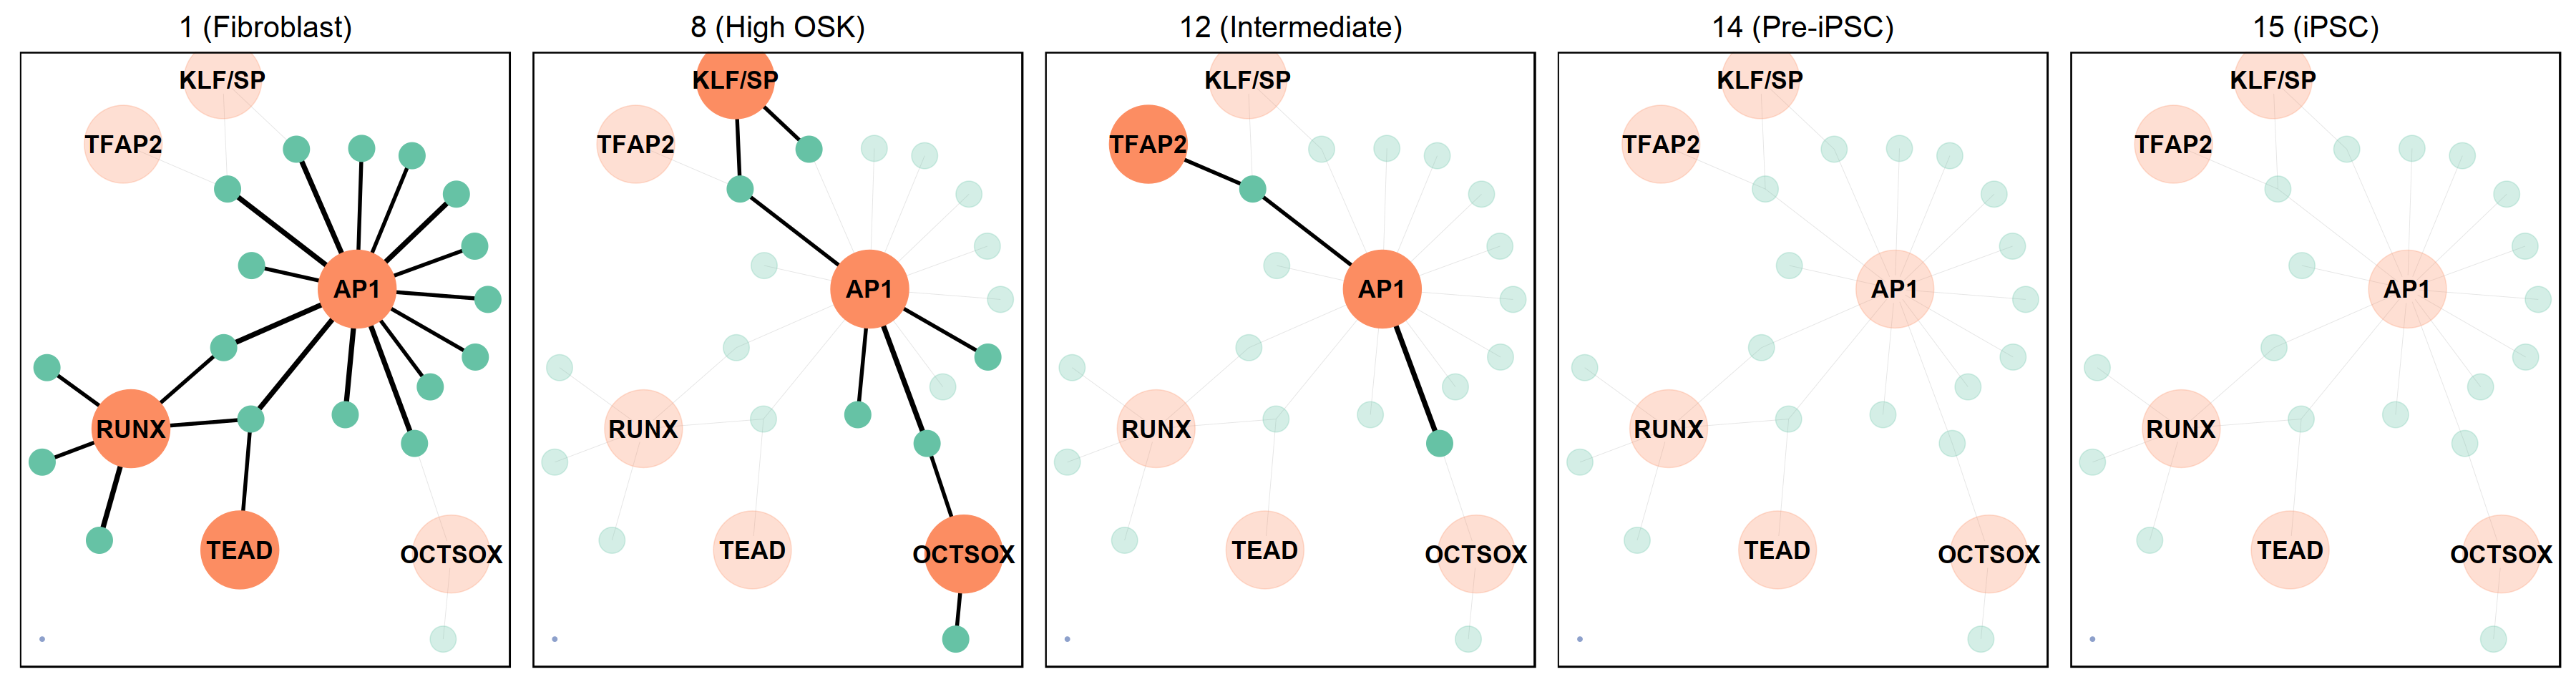

In [362]:
options(repr.plot.width = 30, repr.plot.height = 8)

p = wrap_plots(plots, nrow=1)
p

In [363]:
ggsave("./subfigs/20211225_regulome_FN1.pdf", p, width=30,height=8, useDingbats =F)

In [326]:
MOTIF_SUBSET

PO5F1_MOUSE.H11MO.0.A        SOX15_MA1152.1  KLF3_HUMAN.H11MO.0.B 
             "OCTSOX"                 "SOX"              "KLF/SP" 
        CTCF_MA0139.1  AP2A_MOUSE.H11MO.0.A FOSL2_HUMAN.H11MO.0.A 
               "CTCF"               "TFAP2"                 "AP1" 
RUNX3_HUMAN.H11MO.0.A TEAD4_HUMAN.H11MO.0.A 
               "RUNX"                "TEAD"

In [329]:
x = all_peak_motif[(all_peak_motif$C8_cts!=0),]
x = x[as.character(x$peak) %in% as.character(x$peak)[as.character(x$m) == "PO5F1_MOUSE.H11MO.0.A"], ]
x %>% count(peak) 

x

peak,n
<fct>,<int>
chr10:133024596-133025096,1
chr10:133101007-133101507,2
chr10:133151591-133152091,2
chr10:133232079-133232579,1


,peak,m,C1_cts,C11_cts,C4_cts,C6_cts,C8_cts
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10:133024596-133025096_PO5F1_MOUSE.H11MO.0.A,chr10:133024596-133025096,PO5F1_MOUSE.H11MO.0.A,0,1,1,1,1
chr10:133101007-133101507_KLF3_HUMAN.H11MO.0.B,chr10:133101007-133101507,KLF3_HUMAN.H11MO.0.B,0,3,3,2,2
chr10:133101007-133101507_PO5F1_MOUSE.H11MO.0.A,chr10:133101007-133101507,PO5F1_MOUSE.H11MO.0.A,0,0,0,1,1
chr10:133151591-133152091_KLF3_HUMAN.H11MO.0.B,chr10:133151591-133152091,KLF3_HUMAN.H11MO.0.B,0,1,1,1,1
chr10:133151591-133152091_PO5F1_MOUSE.H11MO.0.A,chr10:133151591-133152091,PO5F1_MOUSE.H11MO.0.A,0,1,1,1,1
chr10:133232079-133232579_PO5F1_MOUSE.H11MO.0.A,chr10:133232079-133232579,PO5F1_MOUSE.H11MO.0.A,0,0,1,1,1


In [339]:
IDX=6
filtered_pwm_hits_per_cluster[[IDX]][queryHits(findOverlaps(filtered_pwm_hits_per_cluster[[IDX]], GRanges("chr10:133232079-133232579")))]

GRanges object with 3 ranges and 4 metadata columns:
      seqnames              ranges strand |                  name         score
         <Rle>           <IRanges>  <Rle> |              <factor>     <numeric>
  [1]    chr10 133232264-133232283      - |  KLF3_HUMAN.H11MO.0.B  12.209759814
  [2]    chr10 133232325-133232337      + |  AP2A_MOUSE.H11MO.0.A 7.54815051294
  [3]    chr10 133232343-133232359      - | PO5F1_MOUSE.H11MO.0.A 9.41479031013
                      seq               imp
                 <factor>         <numeric>
  [1] GAGGGCCCCACCCTGGACC  0.41833665702226
  [2]        GTAGCCTGGAGG 0.374704108969702
  [3]    GCTAGCATAACAATGC 0.654505484073194
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [36]:
all_peak_motif[(all_peak_motif$C11_cts!=0),] # %>% count(peak) %>% filter(n<2) # & grepl("SOX", all_peak_motif$m, ignore.case = T),]

,peak,m,C1_cts,C11_cts,C4_cts,C6_cts,C8_cts
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr2:215410819-215411319_FOSL2_HUMAN.H11MO.0.A,chr2:215410819-215411319,FOSL2_HUMAN.H11MO.0.A,2,2,2,0,0
chr2:215410819-215411319_PO5F1_MOUSE.H11MO.0.A,chr2:215410819-215411319,PO5F1_MOUSE.H11MO.0.A,0,1,0,0,0
chr2:215528502-215529002_FOSL2_HUMAN.H11MO.0.A,chr2:215528502-215529002,FOSL2_HUMAN.H11MO.0.A,2,1,1,0,0
chr2:215528502-215529002_KLF3_HUMAN.H11MO.0.B,chr2:215528502-215529002,KLF3_HUMAN.H11MO.0.B,0,1,0,0,0
chr2:215577270-215577770_FOSL2_HUMAN.H11MO.0.A,chr2:215577270-215577770,FOSL2_HUMAN.H11MO.0.A,1,1,0,0,0
chr2:215657848-215658348_FOSL2_HUMAN.H11MO.0.A,chr2:215657848-215658348,FOSL2_HUMAN.H11MO.0.A,2,1,0,0,0
chr2:215684765-215685265_KLF3_HUMAN.H11MO.0.B,chr2:215684765-215685265,KLF3_HUMAN.H11MO.0.B,0,1,0,0,0
chr2:215412724-215413224_PO5F1_MOUSE.H11MO.0.A,chr2:215412724-215413224,PO5F1_MOUSE.H11MO.0.A,0,1,0,0,0


---

In [177]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] patchwork_1.0.0      network_1.16.1       intergraph_2.0-2    
 [4] igraph_1.2.6         ggnetwork_0.5.8      ggplot2_3.3.3       
 [7] dplyr_1.0.2          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
[10] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 

lo

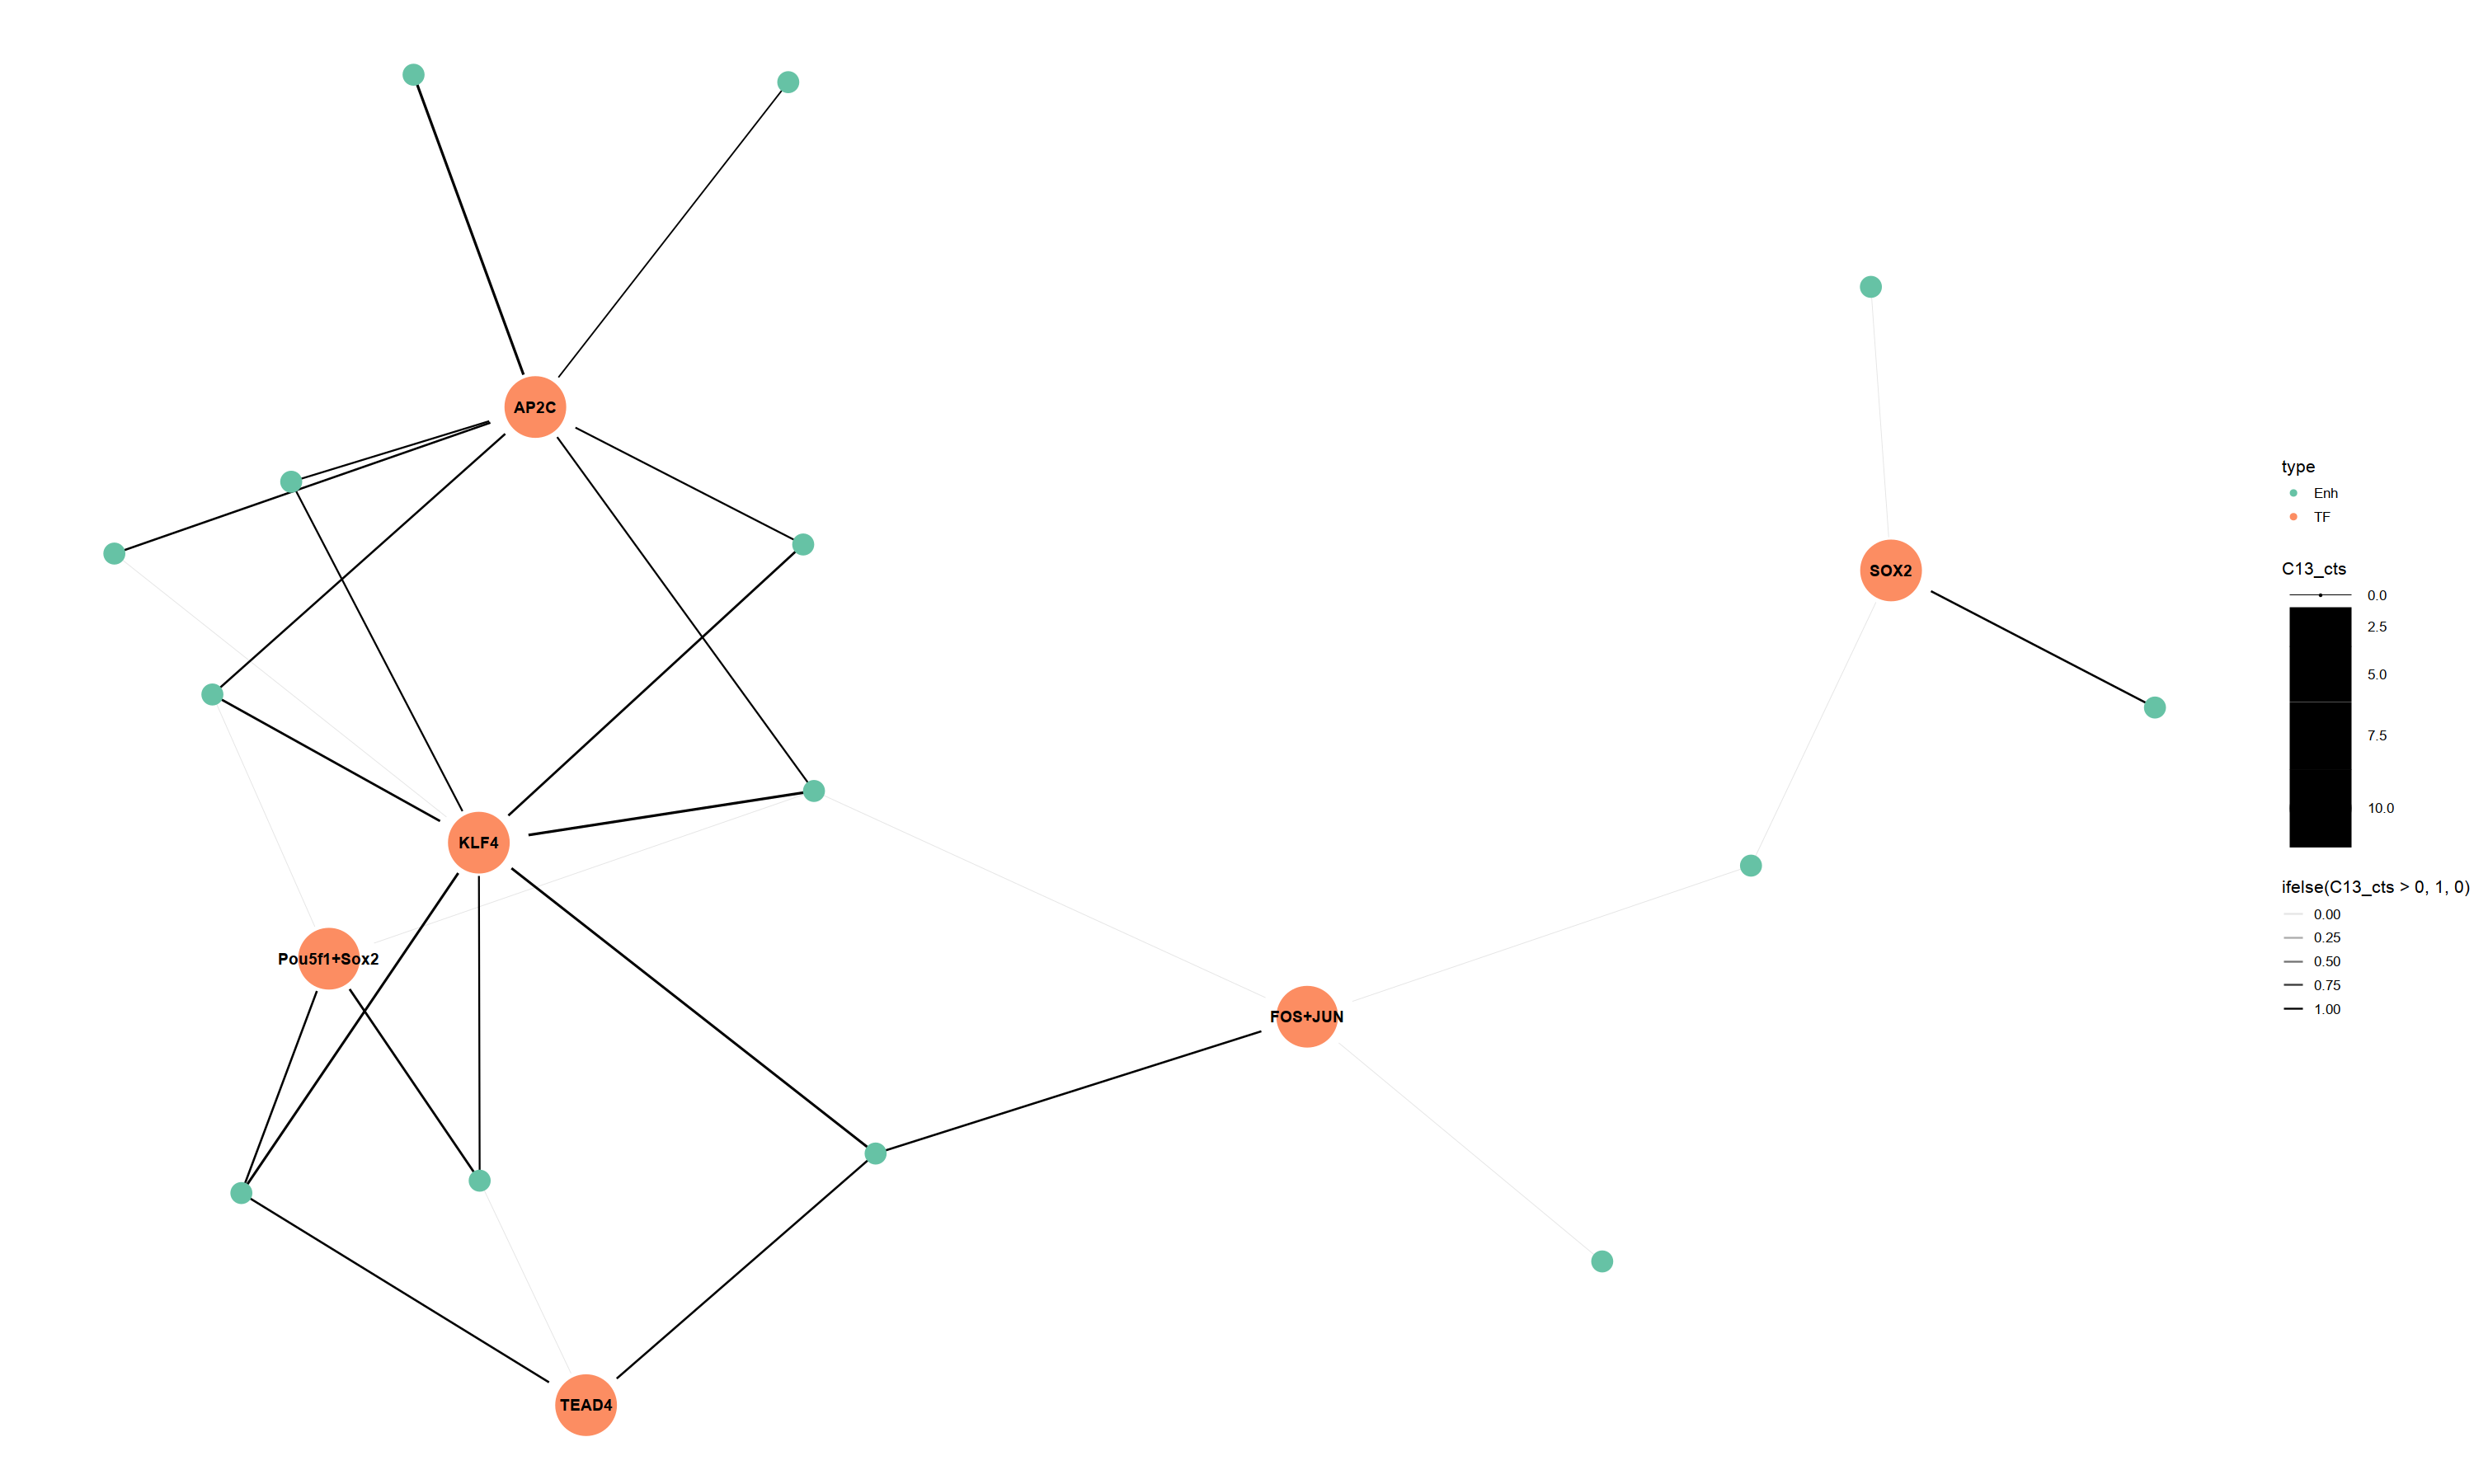

In [736]:
ggplot(plot_g, aes(x = x, y = y, xend = xend, yend = yend)) +
  geom_edges(aes(size=C13_cts, alpha=ifelse(C13_cts>0, 1,0))) +  
  geom_nodes(aes(color = type, size = size)) +
scale_size(range = c(0.2,20)) +
scale_color_brewer(palette = "Set2") +
geom_nodetext(aes(label = print_type),
                fontface = "bold") +
#    scale_size_continuous(range = c(0.2, 1.5)) 
theme_blank()